# ResNet-50


In [224]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import json
import torch.utils.data as data_utils
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn

GPU recommended, the ResNet uses conv2d layers and skip connections, making the training very slow on CPU.

In [225]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cpu')

Load the datasets

In [226]:
# Specify the file path
file_path_train = r'C:\Users\marti\OneDrive\Escritorio\Cours\PIR\metadata_landmarks\metadata_landmarks\train.json'
file_path_test_validation = r'C:\Users\marti\OneDrive\Escritorio\Cours\PIR\metadata_landmarks\metadata_landmarks\validation.json'
img_train_path = r'C:/Users/marti/OneDrive/Escritorio/Cours/PIR/speed/speed/images/train/'
img_test_val_path = r'C:/Users/marti/OneDrive/Escritorio/Cours/PIR/speed/speed/images/test/'


with open(file_path_train, 'r') as file:
    json_train = json.load(file)
    print(f"Len of json_train before cleaning: {len(json_train)}")
    to_remove = []
    #clean missing images
    for i  in range(len(json_train)):
        path = os.path.join(img_train_path,json_train[i]['pose']['filename'])
        if os.path.exists(path) and os.path.isfile(path):
            pass
        else:
            to_remove.append(i)
    
    # Remove entries corresponding to missing images
    for index in sorted(to_remove, reverse=True):
        del json_train[index]

    print(f"Len of json_train after cleaning: {len(json_train)}")    



with open(file_path_test_validation, 'r') as file:
    aux = json.load(file)
    print(f"Len of json_test_&_validation before cleaning: {len(aux)}")
    to_remove = []
    #clean missing images
    for i  in range(len(aux)):
        path = os.path.join(img_test_val_path,aux[i]['pose']['filename'])
        if os.path.exists(path) and os.path.isfile(path):
            pass
        else:
            to_remove.append(i)
    
    # Remove entries corresponding to missing images
    for index in sorted(to_remove, reverse=True):
        del aux[index]

    print(f"Len of json_test_&_validation after cleaning: {len(aux)}") 



torch.manual_seed(40)
json_test,json_validation = data_utils.random_split(aux,[int(0.5*len(aux)),len(aux)-int(0.5*len(aux))])



print("Len json_test:",len(json_test))
print("Len json_validation:",len(json_validation))

Len of json_train before cleaning: 47966
Len of json_train after cleaning: 10767
Len of json_test_&_validation before cleaning: 11994
Len of json_test_&_validation after cleaning: 1763
Len json_test: 881
Len json_validation: 882


Exctract keypoints from json:

In [228]:
def get_keypoints_info(landmark):
    res = []
    for keypoint in landmark:
        res.append(keypoint['x'])
        res.append(keypoint['y'])
        res.append(keypoint['is_inside'])
        res.append(keypoint['is_visible'])
    return res

print(get_keypoints_info(json_train[0]['landmarks']))

[0.5677934885025024, 0.6157256960868835, 1, 1, 0.43038061261177063, 0.5825312733650208, 1, 1, 0.3728139102458954, 0.44611334800720215, 1, 1, 0.5071166753768921, 0.4869178533554077, 1, 0, 0.6154686212539673, 0.5412285327911377, 1, 1, 0.476687490940094, 0.500784158706665, 1, 1, 0.39442214369773865, 0.32109612226486206, 1, 1, 0.5289649963378906, 0.3710699677467346, 1, 1, 0.6510510444641113, 0.5928229987621307, 1, 1, 0.4451993703842163, 0.5378552675247192, 1, 1, 0.3816744089126587, 0.3024238348007202, 1, 1]


Number of keypoints: {NUMBER_OF_KEYPOINTS}

In [229]:
NUMBER_OF_KEYPOINTS = len(json_train[0]['landmarks'])
print(NUMBER_OF_KEYPOINTS)

11


Custom Dataset def:

In [230]:
class CustomDataset(Dataset):
    def __init__(self, dataset,train=True, transform=None):
        self.data = dataset
        self.transform = transform
        self.train = train

    def load_data(self, dataset):
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.train:
            image_path =  os.path.join(img_train_path,sample['pose']['filename'])
        else:
            image_path = os.path.join(img_test_val_path,sample['pose']['filename'])
        coordinates = get_keypoints_info(sample['landmarks'])
        
        # Load image
        image = Image.open(image_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert coordinates to tensor
        coordinates = torch.tensor(coordinates, dtype=torch.float32)

        return image, coordinates


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_train = CustomDataset(json_train,True, transform=transform)
dataset_test = CustomDataset(json_test, False, transform=transform)
dataset_validation = CustomDataset(json_validation, False, transform=transform)


Show one image and tensor to predict:

Length of the dataset: 10767
Sample image shape: torch.Size([3, 256, 256])
Sample coordinates: tensor([0.5678, 0.6157, 1.0000, 1.0000, 0.4304, 0.5825, 1.0000, 1.0000, 0.3728,
        0.4461, 1.0000, 1.0000, 0.5071, 0.4869, 1.0000, 0.0000, 0.6155, 0.5412,
        1.0000, 1.0000, 0.4767, 0.5008, 1.0000, 1.0000, 0.3944, 0.3211, 1.0000,
        1.0000, 0.5290, 0.3711, 1.0000, 1.0000, 0.6511, 0.5928, 1.0000, 1.0000,
        0.4452, 0.5379, 1.0000, 1.0000, 0.3817, 0.3024, 1.0000, 1.0000])


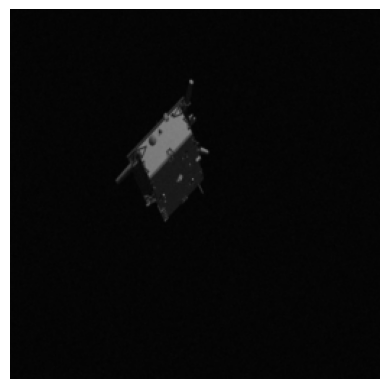

In [231]:
#Print the length of the dataset
print("Length of the dataset:", len(dataset_train))

# Print a sample image and its corresponding coordinates
sample_image, sample_coordinates = dataset_train[0]
print("Sample image shape:", sample_image.shape)
print("Sample coordinates:", sample_coordinates)

# Visualize a sample image from the dataset
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Bottleneck Block

In [232]:
class BottleneckBlock(nn.Module):
    
    expansion = 4  # Expansion factor for the number of output channels

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            # Downsample if the number of channels or spatial dimensions change
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = x  # Store the input for the skip connection

        # First 1x1 convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second 3x3 convolution
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # Third 1x1 convolution (dimensionality restoration)
        out = self.conv3(out)
        out = self.bn3(out)

        # Apply the skip connection if needed
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the skip connection
        out += identity
        out = self.relu(out)

        return out

# Test the BottleneckBlock
block = BottleneckBlock(in_channels=64, out_channels=256)
print(block)


BottleneckBlock(
  (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


# ResNet-50

In [233]:
class ResNet50(nn.Module):

    """
    ResNet-50 architecture implementation.
    
    Args:
        in_channels (int): Number of input channels. Default is 3 for RGB images.
        num_keypoints (int): Number of keypoints to predict. Default is 10.
    """

    
    def __init__(self, in_channels=3, num_keypoints=10):
        super(ResNet50, self).__init__()
        
        # Initial number of channels
        self.in_channels = 64
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization
        self.relu = nn.ReLU(inplace=True)  # ReLU activation
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Max pooling
        
        # Define layers
        self.layer1 = self._make_layer(BottleneckBlock, 64, 3, stride=1)
        self.layer2 = self._make_layer(BottleneckBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BottleneckBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BottleneckBlock, 512, 3, stride=2)
        
        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BottleneckBlock.expansion, num_keypoints*4) # 2 coordinates and 2 booleans for each keypoint
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        Create a layer with multiple bottleneck blocks.
        
        Args:
            block (nn.Module): Type of bottleneck block to use.
            out_channels (int): Number of output channels for the layer.
            blocks (int): Number of bottleneck blocks in the layer.
            stride (int): Stride for the convolutional layers in the blocks. Default is 1.
        
        Returns:
            nn.Sequential: Sequential container for the layer.
        """
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor.
        """
        # Convolutional and pooling layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global average pooling and fully connected layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        # Apply sigmoid for normalized coordinates
        x = torch.sigmoid(x)

        return x

# Testing the ResNet50 implementation
resnet50 = ResNet50()
print(resnet50)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

### Initialize the network, Loss function and Optimizer

In [234]:
resnet50 = ResNet50(3,NUMBER_OF_KEYPOINTS).to(device) # 3 channels for RGB

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(resnet50.parameters())

In [235]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset_validation, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Define a directory to save the model checkpoints
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the interval to save the model checkpoint
CHECKPOINT_INTERVAL = 10  # Save the model every x epochs

# Print loss evolution
PRINT_LOSS = True

# Training loop
NUM_EPOCHS = 100

print(f"Starting Training:")

for epoch in range(NUM_EPOCHS):
    
    # Training phase
    resnet50.train()
    running_loss = 0.0

    
    batch = 0
    for images, targets in train_loader:
        batch+=1
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = resnet50(images)
        # Compute the loss
        loss = criterion(outputs, targets)
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()
        # Print statistics
        running_loss += loss.item() * images.size(0)

        if PRINT_LOSS:
            # Update progress bar with loss value
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]: Batch n°{batch}/{int(len(train_loader))} -> Running Loss: {running_loss/len(test_loader.dataset)}",end='\r')
    

    train_loss = running_loss / len(train_loader.dataset)

    # Testing phase
    resnet50.eval()
    running_test_loss = 0.0
    
    with torch.no_grad():
        for images, targets in test_loader:
            outputs = resnet50(images)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item() * images.size(0)
    
    test_loss = running_test_loss / len(test_loader.dataset)

    # Print statistics
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: '
          f'Training Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}')
    
    # Save the model checkpoint every checkpoint_interval epochs
    if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
        checkpoint_name = f'resnet50_epoch_{epoch+1}.pth'
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
        torch.save(resnet50.state_dict(), checkpoint_path)
        print(f'Model checkpoint saved at: {checkpoint_path}')

# Validation phase 
resnet50.eval()
running_val_loss = 0.0

with torch.no_grad():
    for images, targets in validation_loader:
        outputs = resnet50(images)
        loss = criterion(outputs, targets)
        running_val_loss += loss.item() * images.size(0)

val_loss = running_val_loss / len(validation_loader.dataset)
print(f'Validation Loss: {val_loss:.4f}')

print('Finished Training')

# Example of prediction

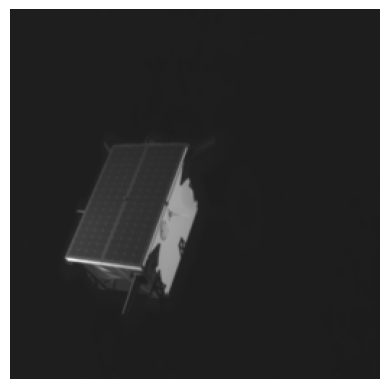

[{'name': 'body_1', 'x': 0.5393739938735962, 'y': 0.4994080066680908, 'is_inside': 1, 'is_visible': 1}, {'name': 'body_2', 'x': 0.505818784236908, 'y': 0.4486953318119049, 'is_inside': 1, 'is_visible': 1}, {'name': 'body_3', 'x': 0.4650077223777771, 'y': 0.5235508680343628, 'is_inside': 1, 'is_visible': 1}, {'name': 'body_4', 'x': 0.5003095269203186, 'y': 0.4566137492656708, 'is_inside': 1, 'is_visible': 1}, {'name': 'panel_1', 'x': 0.5632140636444092, 'y': 0.5065284967422485, 'is_inside': 1, 'is_visible': 1}, {'name': 'panel_2', 'x': 0.5651344060897827, 'y': 0.5378663539886475, 'is_inside': 1, 'is_visible': 1}, {'name': 'panel_3', 'x': 0.5508905649185181, 'y': 0.5575694441795349, 'is_inside': 1, 'is_visible': 1}, {'name': 'panel_4', 'x': 0.5247835516929626, 'y': 0.49187031388282776, 'is_inside': 1, 'is_visible': 1}, {'name': 'antenna_1', 'x': 0.5190740823745728, 'y': 0.488333135843277, 'is_inside': 1, 'is_visible': 1}, {'name': 'antenna_2', 'x': 0.5340123176574707, 'y': 0.593000590801

In [ ]:
test_image_path = r'C:\Users\marti\OneDrive\Escritorio\Cours\PIR\speed\speed\images\real_test\img000015real.jpg'
model_path = r'C:\Users\marti\OneDrive\Escritorio\Cours\PIR\PIR\model_checkpoints\resnet50_epoch_4.pth'

# Load a sample image
sample_image = Image.open(test_image_path).convert('RGB')

# Apply the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

sample_image = transform(sample_image)

# Print the image 
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis('off')
plt.show()


# Add batch dimension
sample_image = sample_image.unsqueeze(0)

# Load the trained model
resnet50 = ResNet50(3,NUMBER_OF_KEYPOINTS).to(device) # 3 channels for RGB 
resnet50.load_state_dict(torch.load(model_path))
resnet50.eval()  # Set the model to evaluation mode

# Perform inference
with torch.no_grad():
    output = resnet50(sample_image)



output=output.numpy()[0]

# Sample landmarks with names
landmarks = [
    {"name": "body_1", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "body_2", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "body_3", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "body_4", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "panel_1", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "panel_2", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "panel_3", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "panel_4", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "antenna_1", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "antenna_2", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
    {"name": "antenna_3", "x": 0, "y": 0, "is_inside": 0, "is_visible": 0},
]

def convert_to_0_1(value):
    if value>0.5:
        return 1
    else:
        return 0
    
# Iterate over the output tensor and assign values to landmarks
for i, landmark in enumerate(landmarks):
    landmark["x"] = output[4*i].item()
    landmark["y"] = output[4*i+1].item()
    landmark["is_inside"] = convert_to_0_1(output[4*i+2].item())
    landmark["is_visible"] = convert_to_0_1(output[4*i+3].item())

# Display the updated landmarks
print(landmarks)
print("\n\nOutput Tensor:",output)
